<a href="https://colab.research.google.com/github/mzaoualim/cryptocurrency_portfolio_optimization_app/blob/main/crypto_portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --quiet
!pip install yahooquery --quiet
!pip install requests_html --quiet
!pip install ydata_profiling --quiet
!pip install PyPortfolioOpt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 739.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.9/344.9 KB 6.8 MB/s eta 0

In [2]:
# Modules imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
from yahooquery import Screener
import requests
from requests_html import HTMLSession
from datetime import datetime
from ydata_profiling import ProfileReport
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

# The goal
Inspired by the G-Reseach competition in [Kaggle](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview) and [this portfolio optimizer tool](https://www.portfoliovisualizer.com/optimize-portfolio)

our goal is to Create a Streamlit App to generate, for a given:
  - porfolio of cryptocurrencies.
  - Budget.
  - Investements withdrawal horizon.

The optimized ratio of chosen currencies with the predicted profits.

# The Data
We'll start with a selection of 3 most popular crypto currencies on the market by market capitalization.

## Getting Data

For scraping historical trading data of the crypto currencies, we rely on Yahoo! finance API.
Fortunatly there is a python [project](https://pypi.org/project/yfinance/) who offers an easy pythonic way to get data.

In [3]:
# Scraping list of 10 most popular crypto tickets (cc)

session = HTMLSession()
num_currencies=10
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
cc = df.Symbol.tolist()
cc

['BTC-USD',
 'ETH-USD',
 'USDT-USD',
 'USDC-USD',
 'BNB-USD',
 'XRP-USD',
 'ADA-USD',
 'HEX-USD',
 'MATIC-USD',
 'DOGE-USD']

In [4]:
# For the given cryptocurrencies, we grab max available histrical closing price data:

tickers = yf.Tickers(cc)
end_date = datetime.now().strftime('%Y-%m-%d')
data = tickers.history(period='max',end=end_date,interval='1d')['Close']
data

[*********************100%***********************]  10 of 10 completed


ADA-USD     BNB-USD       BTC-USD  DOGE-USD      ETH-USD  \
Date                                                                    
2014-09-17       NaN         NaN    457.334015       NaN          NaN   
2014-09-18       NaN         NaN    424.440002       NaN          NaN   
2014-09-19       NaN         NaN    394.795990       NaN          NaN   
2014-09-20       NaN         NaN    408.903992       NaN          NaN   
2014-09-21       NaN         NaN    398.821014       NaN          NaN   
...              ...         ...           ...       ...          ...   
2023-03-05  0.337102  288.699707  22435.513672  0.074795  1564.468750   
2023-03-06  0.330821  288.054962  22429.757812  0.074805  1567.398682   
2023-03-07  0.330483  289.343689  22219.769531  0.074048  1561.933105   
2023-03-08  0.317577  286.867004  21718.080078  0.071130  1534.088257   
2023-03-09  0.309678  277.296112  20363.021484  0.065987  1438.660767   

             HEX-USD  MATIC-USD  USDC-USD  USDT-USD   XRP-USD  
Date                                                           
2014-09-17       NaN        NaN       NaN       NaN       NaN  
2014-09-18       NaN        NaN       NaN       NaN       NaN  
2014-09-19       NaN        NaN       NaN       NaN       NaN  
2014-09-20       NaN        NaN       NaN       NaN       NaN  
2014-09-21       NaN        NaN       NaN       NaN       NaN  
...              ...        ...       ...       ...       ...  
2023-03-05  0.068898   1.137450  1.000010  1.000107  0.367194  
2023-03-06  0.070193   1.131752  0.999953  1.000011  0.370471  
2023-03-07  0.065402   1.149590  1.000081  1.000013  0.380548  
2023-03-08  0.059205   1.051788  0.999869  1.000007  0.389188  
2023-03-09  0.056112   1.015364  1.000008  0.999986  0.372130  

[3096 rows x 10 columns]

## Preprocessing Data

In [5]:
# missing data
data.isna().sum()

ADA-USD      1149
BNB-USD      1149
BTC-USD         0
DOGE-USD     1149
ETH-USD      1149
HEX-USD      1917
MATIC-USD    1684
USDC-USD     1482
USDT-USD     1149
XRP-USD      1149
dtype: int64

In [6]:
# data length before removing missing data
len(data)

3096

In [7]:
# after removing row with missing obs
data = data.dropna(axis=0)
len(data)


1179

These missing data are caused by differences in starting dates of trading of each currency.

In [8]:
data.isna().sum()

ADA-USD      0
BNB-USD      0
BTC-USD      0
DOGE-USD     0
ETH-USD      0
HEX-USD      0
MATIC-USD    0
USDC-USD     0
USDT-USD     0
XRP-USD      0
dtype: int64

In [9]:
data.dtypes

ADA-USD      float64
BNB-USD      float64
BTC-USD      float64
DOGE-USD     float64
ETH-USD      float64
HEX-USD      float64
MATIC-USD    float64
USDC-USD     float64
USDT-USD     float64
XRP-USD      float64
dtype: object

In [10]:
# Save data to csv for future manipulations
data.to_csv('data')

# EDA

In [11]:
data.describe()

ADA-USD      BNB-USD       BTC-USD     DOGE-USD      ETH-USD  \
count  1179.000000  1179.000000   1179.000000  1179.000000  1179.000000   
mean      0.711030   241.571519  28214.851297     0.099346  1661.640314   
std       0.689766   185.142988  16766.375075     0.108710  1239.573776   
min       0.023961     9.386050   4970.788086     0.001537   110.605873   
25%       0.122482    27.709919  11756.164551     0.003200   391.787231   
50%       0.446188   277.296112  22978.117188     0.069125  1552.556519   
75%       1.191118   374.483139  42194.083984     0.146277  2600.766846   
max       2.968239   675.684082  67566.828125     0.684777  4812.087402   

           HEX-USD    MATIC-USD     USDC-USD     USDT-USD      XRP-USD  
count  1179.000000  1179.000000  1179.000000  1179.000000  1179.000000  
mean      0.072550     0.735935     1.000778     1.000613     0.532403  
std       0.099238     0.683911     0.004123     0.002647     0.335006  
min       0.000015     0.008096     0.970124     0.974248     0.139635  
25%       0.004428     0.020953     0.999914     1.000017     0.268584  
50%       0.031410     0.773113     1.000076     1.000255     0.398052  
75%       0.117509     1.251020     1.000372     1.000804     0.752892  
max       0.486741     2.876757     1.044029     1.053585     1.839236

## Pandas Profiling

In [12]:
# Trying  ydata-profiling 
profile = ProfileReport(data, tsmode=True)

In [13]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation Analysis

<AxesSubplot:>

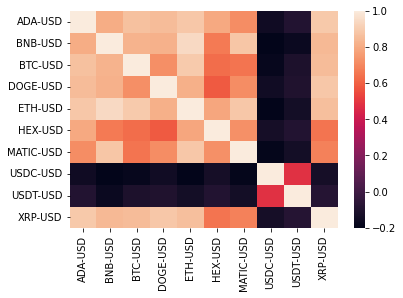

In [14]:
corr = data.corr()

sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

## Volatility Analysis

In [ ]:
# Volatility analysis
# https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/
# https://ionides.github.io/531w22/final_project/project22/blinded.html
# https://colab.research.google.com/github/Shreyav29/Portfolio_Optimization/blob/main/Blog%20-%20MVO%20.ipynb#scrollTo=IfjXPSP1cy2R

In [34]:
np.log(data/data.shift()).rolling(window=365).std()*365**.5

ADA-USD   BNB-USD   BTC-USD  DOGE-USD   ETH-USD   HEX-USD  \
Date                                                                     
2019-12-17       NaN       NaN       NaN       NaN       NaN       NaN   
2019-12-18       NaN       NaN       NaN       NaN       NaN       NaN   
2019-12-19       NaN       NaN       NaN       NaN       NaN       NaN   
2019-12-20       NaN       NaN       NaN       NaN       NaN       NaN   
2019-12-21       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-03-05  0.875416  0.681026  0.606928  1.038068  0.824189  1.354723   
2023-03-06  0.874297  0.680560  0.606465  1.037541  0.823188  1.354767   
2023-03-07  0.873779  0.680355  0.606466  1.037158  0.822913  1.356163   
2023-03-08  0.874548  0.680396  0.606539  1.037889  0.822439  1.359488   
2023-03-09  0.872713  0.680503  0.604187  1.039737  0.822688  1.341791   

            MATIC-USD  USDC-USD  USDT-USD   XRP-USD  
Date                                                 
2019-12-17        NaN       NaN       NaN       NaN  
2019-12-18        NaN       NaN       NaN       NaN  
2019-12-19        NaN       NaN       NaN       NaN  
2019-12-20        NaN       NaN       NaN       NaN  
2019-12-21        NaN       NaN       NaN       NaN  
...               ...       ...       ...       ...  
2023-03-05   1.129297  0.004523  0.005214  0.775644  
2023-03-06   1.128286  0.004498  0.005215  0.774828  
2023-03-07   1.128320  0.004441  0.005214  0.775356  
2023-03-08   1.131577  0.004301  0.005211  0.775732  
2023-03-09   1.131291  0.004299  0.005211  0.774276  

[1179 rows x 10 columns]

In [32]:
import plotly.graph_objects as go
def plot_graph(col,title,xlabel,ylabel,df):
    data = []
    for i in range(len(col)): 
        plot = go.Scatter(x=df.index,y=df[col[i]], name=col[i])
        data.append(plot)
    
    layout = go.Layout(title= title ,
                    xaxis=dict(title=xlabel),
                    yaxis=dict(title=ylabel ), 
                    width = 690, 
                    height = 500, 
                    autosize = True)

    fig = go.Figure(data=data, layout=layout)
    
    fig.show()
    
title = "Volatility"
xlabel = 'Date'
ylabel = 'Close Price'
df = np.log(data/data.shift()).rolling(window=365).std()*365**.5
col = list(data.columns.values)

plot_graph(col,title,xlabel,ylabel,df)

# Modeling

## Base-line Model: Mean-variance optimization

### Optimistic Portfolio

Pursuing the highest gains possible regardless of risks levels.

In [21]:
mu = mean_historical_return(data)
S = CovarianceShrinkage(data).ledoit_wolf()

In [22]:
mu

ADA-USD      0.627265
BNB-USD      0.944421
BTC-USD      0.270876
DOGE-USD     1.108593
ETH-USD      0.693478
HEX-USD      2.453347
MATIC-USD    1.581052
USDC-USD     0.000274
USDT-USD     0.001428
XRP-USD      0.163016
dtype: float64

In [23]:
S

ADA-USD   BNB-USD   BTC-USD  DOGE-USD   ETH-USD   HEX-USD  \
ADA-USD    1.759969  0.164360  0.121582  0.186244  0.173180  0.089680   
BNB-USD    0.164360  1.740071  0.117613  0.130748  0.159408  0.073137   
BTC-USD    0.121582  0.117613  1.598311  0.136055  0.127727  0.069795   
DOGE-USD   0.186244  0.130748  0.136055  2.922295  0.162453  0.089994   
ETH-USD    0.173180  0.159408  0.127727  0.162453  1.686146  0.101362   
HEX-USD    0.089680  0.073137  0.069795  0.089994  0.101362  5.808230   
MATIC-USD  0.237197  0.230379  0.147753  0.166506  0.214632  0.088070   
USDC-USD  -0.001050 -0.001092 -0.000868 -0.001008 -0.001282  0.000796   
USDT-USD  -0.001970 -0.001906 -0.001566 -0.001574 -0.002159  0.005694   
XRP-USD    0.171427  0.155468  0.112798  0.159049  0.157714  0.077683   

           MATIC-USD  USDC-USD  USDT-USD   XRP-USD  
ADA-USD     0.237197 -0.001050 -0.001970  0.171427  
BNB-USD     0.230379 -0.001092 -0.001906  0.155468  
BTC-USD     0.147753 -0.000868 -0.001566  0.112798  
DOGE-USD    0.166506 -0.001008 -0.001574  0.159049  
ETH-USD     0.214632 -0.001282 -0.002159  0.157714  
HEX-USD     0.088070  0.000796  0.005694  0.077683  
MATIC-USD   2.005776 -0.001326 -0.002253  0.210266  
USDC-USD   -0.001326  1.482033  0.000683 -0.001069  
USDT-USD   -0.002253  0.000683  1.482022 -0.001702  
XRP-USD     0.210266 -0.001069 -0.001702  1.800634

In [24]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('ADA-USD', 0.07283), ('BNB-USD', 0.18008), ('BTC-USD', 0.0), ('DOGE-USD', 0.13761), ('ETH-USD', 0.10352), ('HEX-USD', 0.19022), ('MATIC-USD', 0.31574), ('USDC-USD', 0.0), ('USDT-USD', 0.0), ('XRP-USD', 0.0)])


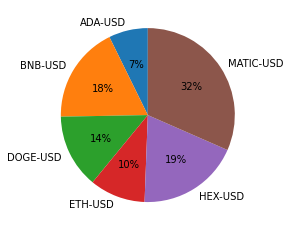

In [25]:
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=False, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [26]:
ef.portfolio_performance(verbose=True)

Expected annual return: 140.6%
Annual volatility: 81.8%
Sharpe Ratio: 1.69


(1.4059726616497066, 0.8181586375325575, 1.6940145811203438)

Crypto trading allow for fraction buy/sell of currencies. so we dont need discrete allocation of coins.

### Risk Averse portfolio

In [27]:
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('ADA-USD', 0.09127), ('BNB-USD', 0.09714), ('BTC-USD', 0.11757), ('DOGE-USD', 0.05564), ('ETH-USD', 0.0981), ('HEX-USD', 0.0345), ('MATIC-USD', 0.06957), ('USDC-USD', 0.1713), ('USDT-USD', 0.17151), ('XRP-USD', 0.09339)])


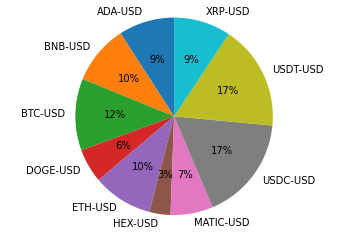

In [28]:
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [29]:
ef.portfolio_performance(verbose=True)

Expected annual return: 52.1%
Annual volatility: 50.3%
Sharpe Ratio: 0.99


(0.5207168573090147, 0.5033226333625881, 0.9948228514260034)

Choosing a more risk averse approach resulted in a diverse portfolio than the earlier approach.

## Machine Learning solution

In [ ]:
#  Tree Based Model

## Deep Learning Solution

In [ ]:
# https://www.quantconnect.com/terminal/processCache/?request=embedded_backtest_4ebbe01bfea8c5ae6f98fcda38a50b1c.html

# Streamlit App

In [ ]:
# Design
#  3 pages app
## page 1: choose (portfolio, budget, horizon)
## page 2: basic EDA (history, volatility...)
## page 3: portfolio ratio/profits/probabilities

# Conclusion

Beyond the App
- Portfolio builder App

# References
[Getting Crypto Symbols](https://stackoverflow.com/a/74656748)

[Portfolio Optimization Using Python](https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb)

[Portfolio Builder](https://github.com/yeungadrian/PortfolioBuilder)

[Portfolio Selection with Graph Algorithms and Deep Learning](https://www.linkedin.com/pulse/portfolio-selection-graph-algorithms-deep-learning-maya-benowitz)

[G-Research Crypto Forecasting](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview)

[G-Research Crypto Forecasting](https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook#Preprocessing)

[yfinance guide](https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance
)

[Portfolio Optimization with PyPortfolioOpt](https://github.com/paulsg3/PortfolioOptimization/blob/main/Portfolio_Optimization.ipynb)

[PyPortfolioOpt Documentation](https://pyportfolioopt.readthedocs.io/en/latest/)

[Portfolio Optimization using Reinforcement Learning](https://github.com/kvsnoufal/portfolio-optimization)

[Multi-level Columns](https://stackoverflow.com/a/56080234)

[On the non-stationarity of financial time series: Impact on optimal portfolio selection](https://www.researchgate.net/publication/224905259_On_the_non-stationarity_of_financial_time_series_Impact_on_optimal_portfolio_selection)

[Stationary TS](https://analyticsindiamag.com/how-to-make-a-time-series-stationary/)

[Volatility Analysis](https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/)

[Volatility Analysis](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/)